# Experiment 2
Here a convolution layer is first used as before, but then two linear layers are used instead of another convolution layer

In [1]:
!ls ../datasets/swat/Physical/

ls: cannot access '../datasets/swat/Physical/': No such file or directory


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from torch.optim import Adam
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_num = 42
set_seed(seed_num)

### Dataset:

In [4]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).mean()
mm = MinMaxScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
validation_set = Normalized[int(0.5 * Normalized.shape[0]) : int(0.7 * Normalized.shape[0])]
train_1 = Normalized[:int(0.5 * Normalized.shape[0])]
train_2 = Normalized[int(0.7 * Normalized.shape[0]):]
train_set = pd.concat([train_1, train_2], axis=0)

In [5]:
df.shape

(99000, 51)

In [6]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size, device):
        self.data = dataframe
        self.window_size = window_size
        self.device = device

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(self.device)
        return features

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [8]:
window_size = 16

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [9]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, X):
        adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        return h
    
    
# A = ReLu(W)    
class Graph_ReLu_W(nn.Module):
    def __init__(self, num_nodes, k, device):
        super(Graph_ReLu_W, self).__init__()
        self.num_nodes = num_nodes
        self.k = k
        
        self.A = nn.Parameter(torch.randn(num_nodes, num_nodes).to(device), requires_grad=True).to(device)

    def forward(self, idx):
        
        adj = F.relu(self.A)
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        return adj

# A for Directed graphs:
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = k
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
        
        return adj

In [10]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, window_size // 2)
        self.conv2 = GCNLayer(window_size // 2, window_size // 4)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(num_nodes * window_size // 4, num_nodes * window_size // 2),
            nn.ReLU(),
            nn.Linear(num_nodes * window_size // 2, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [11]:
num_nodes = 51 
alpha = 0.2
epochs = 50
k = None

In [12]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [13]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=16, out_features=8, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=8, out_features=4, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 16)
      (e2): Embedding(51, 16)
      (l1): Linear(in_features=16, out_features=16, bias=True)
      (l2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=204, out_features=408, bias=True)
    (1): ReLU()
    (2): Linear(in_features=408, out_features=816, bias=True)
  )
)

In [14]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [15]:
model_path = 'AE_downsampling_seed_' + str(seed_num) + '.pth'

In [16]:
%%time
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')
    if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.012:
        continue
    if round(torch.stack(running_loss_AE1).mean().item(), 4) == round(AE1_val_history[-1], 4):
        break

Epoch: 0 ---> Val loss: AE1 0.0343
Train loss: AE1 0.1932
Epoch: 1 ---> Val loss: AE1 0.0307
Train loss: AE1 0.0409
Epoch: 2 ---> Val loss: AE1 0.0263
Train loss: AE1 0.0319
Epoch: 3 ---> Val loss: AE1 0.0195
Train loss: AE1 0.0269
Epoch: 4 ---> Val loss: AE1 0.0122
Train loss: AE1 0.0194
Epoch: 5 ---> Val loss: AE1 0.0073
Train loss: AE1 0.0130
Epoch: 6 ---> Val loss: AE1 0.0044
Train loss: AE1 0.0075
Epoch: 7 ---> Val loss: AE1 0.0028
Train loss: AE1 0.0050
Epoch: 8 ---> Val loss: AE1 0.0024
Train loss: AE1 0.0036
Epoch: 9 ---> Val loss: AE1 0.0022
Train loss: AE1 0.0031
Epoch: 10 ---> Val loss: AE1 0.0021
Train loss: AE1 0.0028
Epoch: 11 ---> Val loss: AE1 0.0021
Train loss: AE1 0.0026
Epoch: 12 ---> Val loss: AE1 0.0020
Train loss: AE1 0.0024
Epoch: 13 ---> Val loss: AE1 0.0019
Train loss: AE1 0.0023
Epoch: 14 ---> Val loss: AE1 0.0018
Train loss: AE1 0.0021
Epoch: 15 ---> Val loss: AE1 0.0017
Train loss: AE1 0.0020
Epoch: 16 ---> Val loss: AE1 0.0016
Train loss: AE1 0.0018
Epoch: 

# Testing

In [17]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
df2.columns = df2.columns.str.strip()
df2['attack'] = df2['Normal/Attack'].map({'Normal': 0, 'Attack': 1, 'A ttack': 1})
df2 = df2.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df2)) // 5
df2 = df2.groupby(grouping_array).median()
labels = df2['attack']
df2 = df2.drop(columns=['attack'])

In [18]:
test_normalized = pd.DataFrame(mm.fit_transform(df2))

In [19]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [20]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [21]:
labels = labels.values
labels = [0 if (lab == 0) else 1 for lab in labels]

In [22]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [23]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [24]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [25]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                       results[-1].flatten().detach().cpu().numpy()])

In [26]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

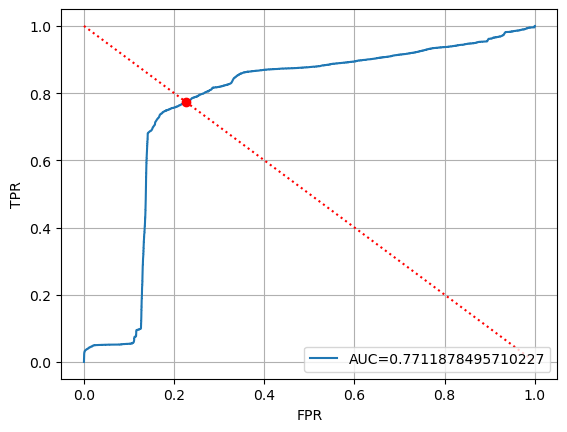

array([0.01086963], dtype=float32)

In [27]:
threshold = ROC(y_test,y_pred)
threshold

best: 0.01875 F1: 0.5129233804669517


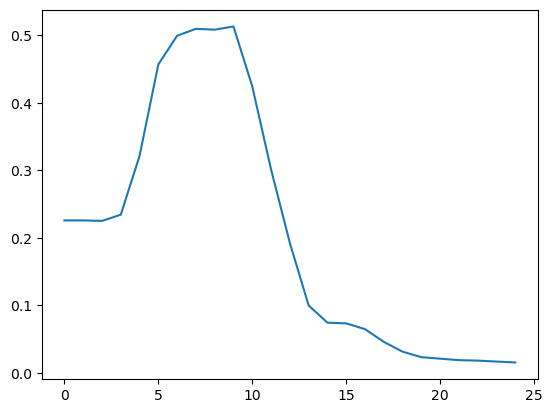

In [28]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.05, 25):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [29]:
labels = labels[window_size:]
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

best: 0.03469387755102041 F1: 0.8391262674670837


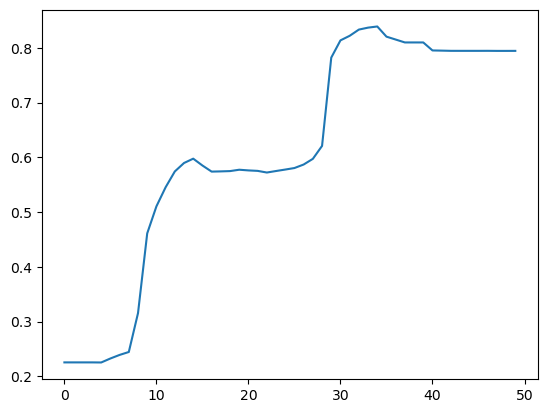

In [30]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.05, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)